In [3]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
from  torchvision.datasets import ImageFolder
from torch.autograd import Variable
import cv2
import numpy as np
import os, random,sys


# Build an Autoencoder for a human face dataset

We will use a dataset containig images of people and train an autoencoder on it.

## Step 1

Download and unzip the ``lfw.zip`` file . Adjust the ``path`` variable so that it contains the address of the unzipped folder. We will create a dataloader from this folder.


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!unzip /content/drive/MyDrive/lfw.zip

Streaming output truncated to the last 5000 lines.
  inflating: lfw/Recep_Tayyip_Erdogan/Recep_Tayyip_Erdogan_0021.jpg  
  inflating: __MACOSX/lfw/Recep_Tayyip_Erdogan/._Recep_Tayyip_Erdogan_0021.jpg  
  inflating: lfw/Recep_Tayyip_Erdogan/Recep_Tayyip_Erdogan_0020.jpg  
  inflating: __MACOSX/lfw/Recep_Tayyip_Erdogan/._Recep_Tayyip_Erdogan_0020.jpg  
  inflating: lfw/Recep_Tayyip_Erdogan/Recep_Tayyip_Erdogan_0008.jpg  
  inflating: __MACOSX/lfw/Recep_Tayyip_Erdogan/._Recep_Tayyip_Erdogan_0008.jpg  
  inflating: lfw/Recep_Tayyip_Erdogan/Recep_Tayyip_Erdogan_0022.jpg  
  inflating: __MACOSX/lfw/Recep_Tayyip_Erdogan/._Recep_Tayyip_Erdogan_0022.jpg  
  inflating: lfw/Recep_Tayyip_Erdogan/Recep_Tayyip_Erdogan_0023.jpg  
  inflating: __MACOSX/lfw/Recep_Tayyip_Erdogan/._Recep_Tayyip_Erdogan_0023.jpg  
  inflating: lfw/Recep_Tayyip_Erdogan/Recep_Tayyip_Erdogan_0012.jpg  
  inflating: __MACOSX/lfw/Recep_Tayyip_Erdogan/._Recep_Tayyip_Erdogan_0012.jpg  
  inflating: lfw/Recep_Tayyip_Erdogan/Recep

In [6]:
path = '/content/lfw'

In [7]:
transform    = transforms.Compose([transforms.ToTensor()])
dataloader = DataLoader(ImageFolder(path, transform,),batch_size=32, shuffle=True)


This project is compute intensive. If you have a cuda or mps device on your laptop make sure you use that in the training.

In [8]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    print ("MPS device not found.")


MPS device not found.


torch.Size([250, 250, 3])


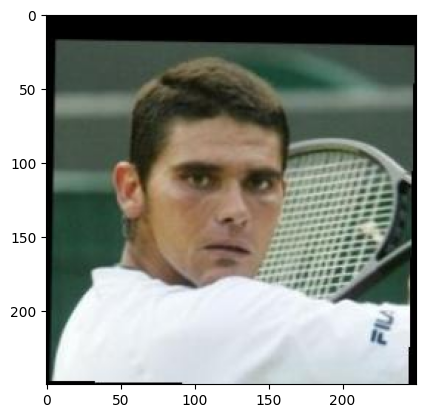

In [9]:
for x,y in dataloader:
    x = x[0].permute(1, 2, 0)
    print(x.shape)
    plt.imshow(x)
    break

## Step 2
Each datapoint is an image. Get a sample of the data and print its dimensions and explain what each dimension means.

In [33]:
import torch
from torchvision import transforms

# Assuming 'dataloader' is your DataLoader from the previous code

# Get a sample batch
sample_batch, _ = next(iter(dataloader))

# Print dimensions and explanation
print("Sample Batch Dimensions:", sample_batch.shape)

# Explanation
batch_size, channels, height, width = sample_batch.shape
print(f"Batch Size: {batch_size}")
print(f"Number of Channels (e.g., RGB): {channels}")
print(f"Image Height: {height}")
print(f"Image Width: {width}")

Sample Batch Dimensions: torch.Size([32, 3, 250, 250])
Batch Size: 32
Number of Channels (e.g., RGB): 3
Image Height: 250
Image Width: 250


The first dimension represents the batch size, which is the number of samples (images in this case) processed together in a single forward or backward pass through the neural network. In this example, there are 32 images in each batch. The second dimension represents the number of color channels in each image. For RGB (Red, Green, Blue) images, this value is 3, as there are three color channels for each pixel. The third dimension represents the height of each image in pixels. In this example, each image has a height of 250 pixels.The fourth dimension represents the width of each image in pixels. In this example, each image has a width of 250 pixels.

# Step 3

Create a new pytorch model calss for your autoencoder. You can use Conv2d, MaxPool2d, BatchNorm2d, ConvTranspose2d and Linear Layers as as well as activation functions. Optionally, you can use UpSample, AveragePool2d and Interpolate2d as well.

**Create seperate functions for the encoder and decoder.**

In [93]:
import torch
import torch.nn as nn

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # Encoder
        self.encoder = self.build_encoder()

        # Decoder
        self.decoder = self.build_decoder()

    def build_encoder(self):
        encoder_layers = [
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2)
        ]
        return nn.Sequential(*encoder_layers)

    def build_decoder(self):
        decoder_layers = [
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Upsample(scale_factor=2, mode='nearest'),  # or use nn.ConvTranspose2d
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Upsample(scale_factor=2, mode='nearest'),  # or use nn.ConvTranspose2d
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        ]
        return nn.Sequential(*decoder_layers)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x






## Step 4
Create an instance of the class, pass an image to the model, print the shape of the output of the **encoder** and the **decoder**. Check the dimensions and make sure your forward path is working properly.

In [95]:
# Create an instance of the Autoencoder model
model = Autoencoder()

In [96]:
# Print the model architecture
print(model)

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): ReLU()
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, m

In [97]:
import torch
from PIL import Image
from torchvision import transforms

# Assuming 'Autoencoder' is your Autoencoder class from the previous code

# Create an instance of the Autoencoder model
model = Autoencoder()

# Load and preprocess an example image
image_path = '/content/lfw/Aaron_Eckhart/Aaron_Eckhart_0001.jpg'
image = Image.open(image_path).convert('RGB')  # Assuming RGB image
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize to match the model's expected input size
    transforms.ToTensor(),
])

input_image = transform(image).unsqueeze(0)  # Add batch dimension

# Forward pass through the autoencoder
output_image = model(input_image)

# Print the shapes of the encoder and decoder outputs
encoded_output = model.encoder(input_image)
decoded_output = model.decoder(encoded_output)

print(f"Input Image Shape: {input_image.shape}")
print(f"Encoded Output Shape: {encoded_output.shape}")
print(f"Decoded Output Shape: {decoded_output.shape}")


Input Image Shape: torch.Size([1, 3, 256, 256])
Encoded Output Shape: torch.Size([1, 128, 4, 4])
Decoded Output Shape: torch.Size([1, 3, 128, 128])


##  Step 5
Print total number of parameters in the model, explain what loss function you should use, create an optimizer for training

In [101]:
pip install pytorch-msssim


In [102]:
import torch
import torch.nn as nn
from torch.optim import Adam
from pytorch_msssim import ssim

# Assuming 'Autoencoder' is your Autoencoder class from the previous code

# Create an instance of the Autoencoder model
model = Autoencoder()

# Print total number of parameters in the model
total_params = sum(p.numel() for p in model.parameters())
print(f"Total Parameters: {total_params}")

# Choose a loss function suitable for autoencoder (Structural Similarity Index - SSIM)
def ssim_loss(x, y):
    return 1 - ssim(x, y, data_range=1.0)

# Create an optimizer (e.g., Adam optimizer) for training
optimizer = Adam(model.parameters(), lr=0.001)

# Define the loss function
loss_function = ssim_loss

# Print Loss function and Optimizer
print("Loss Function:", loss_function)
print("Optimizer:", optimizer)


Total Parameters: 331715
Loss Function: <function ssim_loss at 0x788f22411d80>
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)


Using SSI as a loss function in an autoencoder goes beyond pixel-wise accuracy and aims to improve the perceptual quality of reconstructed images by considering structural similarities. This can be particularly valuable in tasks where human perception and image quality are essential.

##  Step 6
Write a training loop and start trainng the model for several epochs. Report the loss value at the end of each epoch and monitor it. If your loss is not decreasing what do you have to do to troubleshoot it ?

In [103]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.optim import Adam
from torch.nn import MSELoss
from PIL import Image
from tqdm import tqdm

# Assuming 'Autoencoder' is your Autoencoder class, 'dataloader' is your DataLoader,
# and 'criterion' and 'optimizer' are defined as shown in the previous examples

# Training parameters
num_epochs = 10

# Function to train the model for one epoch
def train_epoch(model, dataloader, criterion, optimizer):
    model.train()
    total_loss = 0.0

    for data in tqdm(dataloader, desc='Training'):
        input_image, _ = data
        optimizer.zero_grad()

        # Forward pass
        output_image = model(input_image)

        # Resize target image to match the output size
        target_image_resized = F.interpolate(input_image, size=output_image.shape[2:], mode='nearest')

        # Calculate the loss
        loss = criterion(output_image, target_image_resized)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    return avg_loss


# Train the model for multiple epochs
for epoch in range(num_epochs):
    # Training
    avg_train_loss = train_epoch(model, dataloader, criterion, optimizer)

    # Print the average loss at the end of each epoch
    print(f"Epoch [{epoch + 1}/{num_epochs}], Average Training Loss: {avg_train_loss:.4f}")

    # Optionally, you can add validation here if you have a validation set

    # Check if the loss is decreasing
    if epoch > 0 and avg_train_loss >= prev_avg_train_loss:
        print("Training loss is not decreasing. Consider adjusting the learning rate or model architecture.")

    # Update the previous loss for the next iteration
    prev_avg_train_loss = avg_train_loss


Training: 100%|██████████| 414/414 [08:33<00:00,  1.24s/it]


Epoch [1/10], Average Training Loss: 0.0340


Training: 100%|██████████| 414/414 [08:22<00:00,  1.21s/it]


Epoch [2/10], Average Training Loss: 0.0243


Training: 100%|██████████| 414/414 [08:25<00:00,  1.22s/it]


Epoch [3/10], Average Training Loss: 0.0222


Training: 100%|██████████| 414/414 [08:27<00:00,  1.23s/it]


Epoch [4/10], Average Training Loss: 0.0211


Training: 100%|██████████| 414/414 [08:18<00:00,  1.20s/it]


Epoch [5/10], Average Training Loss: 0.0203


Training: 100%|██████████| 414/414 [08:24<00:00,  1.22s/it]


Epoch [6/10], Average Training Loss: 0.0196


Training: 100%|██████████| 414/414 [08:22<00:00,  1.21s/it]


Epoch [7/10], Average Training Loss: 0.0192


Training: 100%|██████████| 414/414 [08:20<00:00,  1.21s/it]


Epoch [8/10], Average Training Loss: 0.0188


Training: 100%|██████████| 414/414 [08:20<00:00,  1.21s/it]


Epoch [9/10], Average Training Loss: 0.0185


Training: 100%|██████████| 414/414 [08:11<00:00,  1.19s/it]

Epoch [10/10], Average Training Loss: 0.0182


If your loss is not decreasing during training, it indicates that the model is not learning as expected. Here are some common troubleshooting steps to address this issue:
1. Learning Rate
2. Model Complexity
3. Overfitting
4. Data Issues
5. Normalization
6. Check Gradients
7. Loss Function
8. Evaluate on Validation Set
9. Monitor Training Process
10. Train Longer

##  Step 7

Take a random image from the dataset and plot it against the reconstructed (encoded + decoded) image.

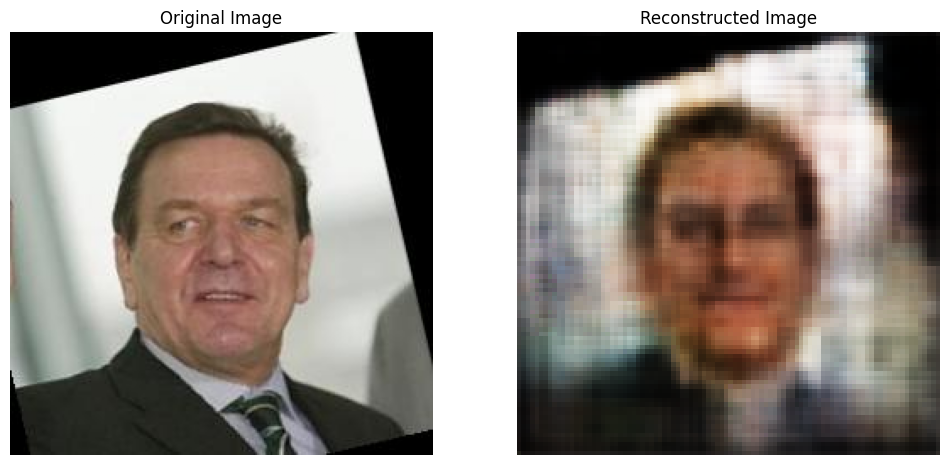

In [104]:
# Assuming you have a GPU and want to use it if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Get a single batch from the dataloader
dataiter = iter(dataloader)
images, _ = next(dataiter)

# Select the first image from the batch
original_image = images[0]
original_image_np = original_image.numpy().transpose(1, 2, 0)

# Move the image to the device and add a batch dimension
input_image = original_image.unsqueeze(0).to(device)

# Pass the image through your autoencoder
with torch.no_grad():
    reconstructed = model(input_image)
    reconstructed_np = reconstructed.cpu().squeeze(0).numpy().transpose(1, 2, 0)

# Ensure that the pixel values are in the [0, 1] range
reconstructed_np = np.clip(reconstructed_np, 0, 1)

# Plot the original and reconstructed images
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(original_image_np)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(reconstructed_np)
plt.title("Reconstructed Image")
plt.axis('off')

plt.show()


##  Step 8

In step 7, add a small normaly distrubuted noise to the latent (hidden) representation of the input image and then decode it again. How is adding noise affecting the decoded image ?

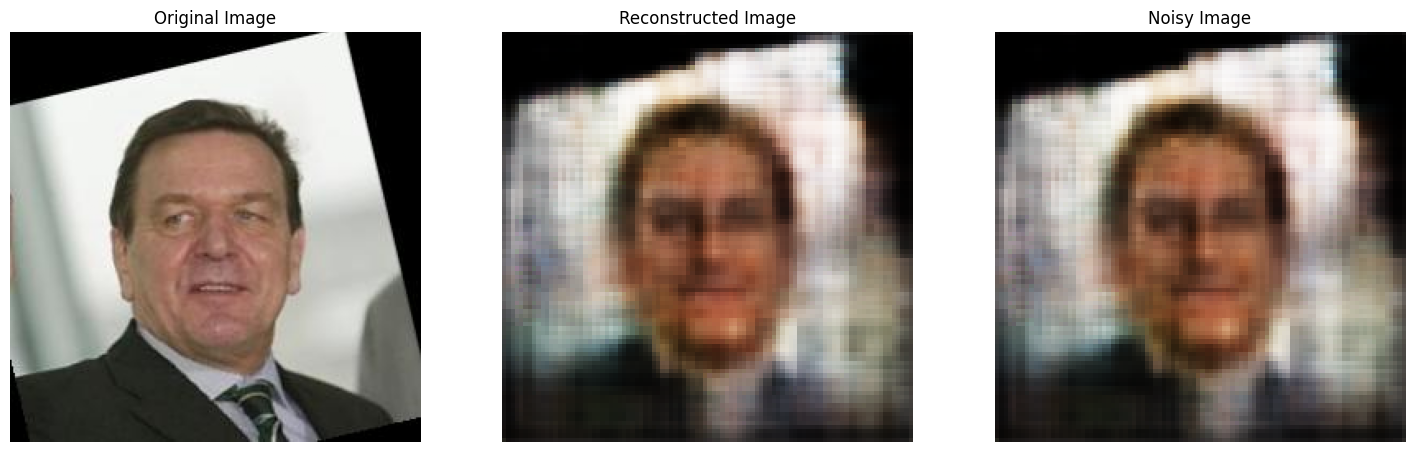

In [105]:
import torch.nn.functional as F

# Assuming you already have 'model' and 'input_image' from the previous code

# Pass the image through the encoder to get the latent representation
with torch.no_grad():
    latent_representation = model.encoder(input_image)

# Add small Gaussian noise to the latent representation
noise = torch.randn_like(latent_representation) * 0.1  # Adjust the standard deviation as needed
noisy_latent_representation = latent_representation + noise

# Decode the noisy latent representation
noisy_reconstructed = model.decoder(noisy_latent_representation)

# Move tensors to CPU and convert to NumPy arrays for visualization
input_image_np = input_image.cpu().squeeze(0).numpy().transpose(1, 2, 0)
noisy_reconstructed_np = noisy_reconstructed.cpu().detach().squeeze(0).numpy().transpose(1, 2, 0)

# Plot the original, noisy, and reconstructed images
plt.figure(figsize=(18, 6))


plt.subplot(1, 3, 1)
plt.imshow(input_image_np)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(reconstructed_np)
plt.title("Reconstructed Image")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(noisy_reconstructed_np)
plt.title("Noisy Image")
plt.axis('off')



plt.show()



Adding noise to the encoded representation of an image and then decoding it can serve as a form of regularization and can have several effects on the decoded image and the training process in an autoencoder:
1. Noise as Regularization
2. Smoothing Effect
3. Reducing Overfitting
4. Improving Generalization

Adding noise during training in an autoencoder can have positive effects on regularization, generalization, and denoising abilities. The optimal amount of noise depends on the specific task, dataset, and desired properties of the learned representations. It's often a hyperparameter that requires experimentation and tuning during the training process.